In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import pandas as pd
from mpl_toolkits import mplot3d

In [2]:
rho_g_per_cm3 = 1.255184 #g/cm^3, 6M KOH
density = rho_g_per_cm3*1000 #kg/m^3
g = 9.81 #m/s^2
gamma = density*g #N/m^3
cm = 0.01 #m

#### Reynolds Number Calculation for Noncircular Ducts

The Reynolds number is calculated using the hydraulic diameter, $D_h = 4A/P$ $[m]$, average linear velocity, $v$ $[m/s]$, and kinematic viscosity, $\nu$ $[m^2/s]$.

\begin{equation}
Re_h = \frac{D_hv}{\nu}
\end{equation}

In [3]:
def calculate_reynolds(reactor_width, cat_length):
    '''
    takes in the length of the cathode [m], assuming a flat square cathode,
    and the reactor width[m], and calculates Re for a square duct
    '''
    #D_h = 4A/P
    hydraulic_diameter = 4*cat_length*reactor_width / (2*cat_length + 2*reactor_width)
    linear_velocity = 0.13263 #m/s
    kinematic_viscosity_cm = 0.0149 #cm^2/s
    kinematic_viscosity = kinematic_viscosity_cm/(100**2) #m^2/s
    
    Re = hydraulic_diameter*linear_velocity/kinematic_viscosity
    
    ratio = cat_length/reactor_width
#     print('Aspect ratio is {:.2f}'.format(ratio))
#     print(reactor_width)
    return Re, ratio

(2500, 2)


(0.3310810810810811, 0.01, 1337.4605662112901, 1762.6420360156824)

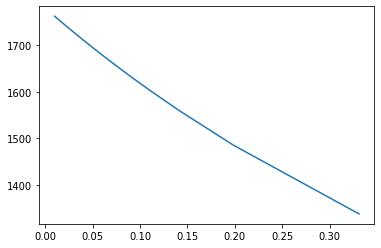

In [4]:
widths = np.linspace(0.01, 1) #range of values from 1cm to 1m
# heights = np.ones_like(widths)
heights = np.linspace(0.01, 1)

geometries = np.array(np.meshgrid(heights,widths)).T.reshape(-1,2)
reynolds = np.zeros_like(geometries[:,0])
ratios = np.zeros_like(geometries[:,0])
print(np.shape(geometries))

#reynolds = array of reynolds #s 
for i in range(len(geometries)):
    reynolds[i], ratios[i] = calculate_reynolds(geometries[i,0],geometries[i,1])

lam_re = []
lam_ratios = []
for i in range(len(reynolds)):
    if reynolds[i] < 2300 and ratios[i]<1: #laminar
        lam_re.append(reynolds[i])
        lam_ratios.append(ratios[i])
#         print(ratios[i])
lam_re

plt.plot(lam_ratios,lam_re)
max(lam_ratios), min(lam_ratios), min(lam_re), max(lam_re)

### Calculating the pressure drop in a noncircular duct

For laminar flow in a noncircular duct:
\begin{equation}
f = \frac{C}{\text{Re}_h}
\end{equation}

head loss, $h_L$, can be calculated by:
\begin{equation}
h_L = f\frac{l}{D_h}\frac{V^2}{2g}
\end{equation}

Then the pressure drop can be found by: 
\begin{equation}
\Delta p = \gamma  h_L
\end{equation}

<img src="Calculate_C.png" alt="Drawing" style="width: 800px;"/>


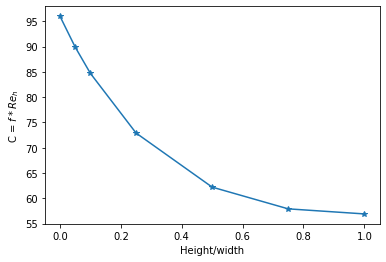

In [5]:
ratios = [0,0.05,0.1,0.25,0.5,0.75,1.0]
Cs = [96.0,89.9,84.7,72.9,62.2,57.9,56.9]
plt.plot(ratios,Cs,'-*')
plt.xlabel('Height/width')
plt.ylabel('C = $f*Re_h$')
plt.show()

In [6]:
#interpolating tabulated data 
def find_C(ratio):
    ratios = [0,0.05,0.1,0.25,0.5,0.75,1.0]
    Cs = [96.0,89.9,84.7,72.9,62.2,57.9,56.9]
    return np.interp(ratio,ratios,Cs)

find_C(.3)

70.76

In [7]:
def pressure_drop(h,w):
    
    L = h #square catalyst as side
    hydraulic_diameter = 4*h*w/(2*h+2*w)
    linear_velocity = 0.13263 #m/s
    kinematic_viscosity_cm = 0.0149 #cm^2/s
    kinematic_viscosity = kinematic_viscosity_cm/(100**2)
    
    Re_h = hydraulic_diameter*linear_velocity/kinematic_viscosity
    ratio = h/w #or vice versa? 
    
    C = find_C(ratio)
    f = C/Re_h
    
    head_loss = f*L/hydraulic_diameter*linear_velocity**2/(2*g)
    pressure_drop = gamma*head_loss
     
    return pressure_drop, head_loss #N/m^2

In [8]:
final_height,final_width = 1, .01

pd, head = pressure_drop(final_height,final_width)
p_bar = 1e-5*pd
print('Pressure drop: {:.2e} bar'.format(p_bar))

Pressure drop: 1.80e-04 bar


### Calculating Pump Power

source: https://www.aiche.org/resources/publications/cep/2016/december/pump-sizing-bridging-gap-between-theory-and-practice

\begin{equation}
P = \frac{Q \rho g H}{3.6x10^6 \eta}
\end{equation}

where P is the pump power (kW), Q is the flowrate (m3/hr), H is the total pump head (m of fluid), and η is the pump efficiency (if you do not know the efficiency, use η = 0.7). 

In [9]:
#flowrate = hw*linear_velocity
final_height,final_width = 1, .1*cm
h = final_height
w = final_width
linear_velocity = 0.13263 #m/s
Q = h*w*linear_velocity #m^3/s
Q_hr = 3600*Q
pump_efficiency = 0.7 #AichE Paper said to use this if we don't know

Power = Q_hr*density*g*head/(pump_efficiency*3.6e6) #kW
Power

print(Q*1000*60)
print('Pump power = {:.2e} kW'.format(Power)) #kW
print('Note: This is only based on the pressure drop across 1 cell. \nConsider adding considerations for piping, fittings, geometry change.')

7.9578
Pump power = 3.41e-06 kW
Note: This is only based on the pressure drop across 1 cell. 
Consider adding considerations for piping, fittings, geometry change.


### Calculating Pump power for a given width [m]

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
def POWER(w):
    '''
    takes w in meters
    returns Power in kW
    '''
    
    h = 1
    L = h #square catalyst as side
    hydraulic_diameter = 4*h*w/(2*h+2*w)
    linear_velocity = 0.13263 #m/s
    kinematic_viscosity_cm = 0.0149 #cm^2/s
    kinematic_viscosity = kinematic_viscosity_cm/(100**2)
    
    Re_h = hydraulic_diameter*linear_velocity/kinematic_viscosity
    ratio = h/w  
    
    C = find_C(ratio)
    f = C/Re_h
    
    head_loss = f*L/hydraulic_diameter*linear_velocity**2/(2*g)
    pressure_drop = gamma*head_loss
    
    linear_velocity = 0.13263 #m/s
    Q = h*w*linear_velocity #m^3/s
    Q_hr = 3600*Q
    
#     Q_hr = 4.77468 #keeping volumetric flow rate constant: (change this later !!)
    
    pump_efficiency = 0.7 #AichE Paper said to use this if we don't know
    
    Power = Q_hr*density*g*head_loss/(pump_efficiency*3.6e6) #kW
     
    return Power #kW

#pass 'interact' the function and then the variable name u will change
#=(min,max,step)
interact(POWER,w=(.005,.5)) #kW for widths from .5cm to 50cm

interactive(children=(FloatSlider(value=0.2525, description='w', max=0.5, min=0.005), Output()), _dom_classes=…

<function __main__.POWER(w)>

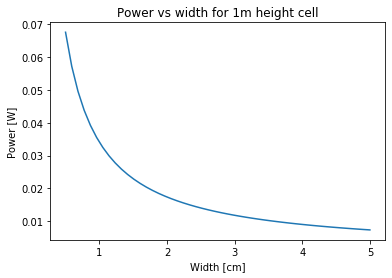

0.06752483953858048

In [12]:
cm = 0.01 #m
ws = np.linspace(.005,.05) #0.5 to 5cm
powers = POWER(ws)
plt.plot(ws*100,powers*1000)
plt.xlabel('Width [cm]')
plt.ylabel('Power [W]')
plt.title('Power vs width for 1m height cell')
plt.show()

POWER(.5*cm)*1000

# How to deliver electrolyte to the cell
_Based on Choi et al. doi 10.1007/s12206-018-0203-z_

<img src="choi_fig2.png" alt="Drawing" style="width: 300px;"/>

Large main pipe $\rightarrow$ smaller **rectangular** guide channels $\rightarrow$ buffer region (microstructures in parallel so flow is uniform upon reaching the active area) $\rightarrow$ main active area rectangular channel

Specifying the width of the main channel specifies the cell flow rate and geometry of buffer region. Number and diameter of guide channels then can be calculated to minimize pressure head and shunt current.

\begin{equation}
q_{C} = \sum_{i = 1}^{N_{G}} q_{G,i} = q_B
\end{equation}

where $q_C$ is the volumetric flow rate through the cell, $q_{G,i}$ is the volumetric flow rate through the $i^{th}$ guide channel, and $q_B$ is the volumetric flow rate through the buffer region.

### Their info

In [13]:
cm = 0.01 #m

#Mainfold dimensions (pipe connecting cells)
manifold_diameter = 2.54*cm
height_manifold = 1.65*cm #(between 2 cells)

#Guide channel dimensions
gc_len = 32*cm
gc_height = 0.1*cm
gc_width = 0.3*cm
gc_ax = gc_height*gc_width #cross-sectional area

#Buffer region dimensions
##

#Cell dimensions
h = 26*cm
l = 30*cm
w = 0.3*cm
active_area = h*l #m^2
cell_ax = l*w #m^2

#Quantities
N_cells = 15
Q_cell_lpm = 0.2 #L/min/cell
Q_cell = 0.2/1000/60 #m^3/s/cell
v_cell = Q_cell/cell_ax #m/s

print(f"Their linear velocity is {linear_velocity/v_cell:.0f}x slower than ours!\nTheirs: {v_cell:4.2e} m/s\nOurs: {linear_velocity:10.2e} m/s")

Their linear velocity is 36x slower than ours!
Theirs: 3.70e-03 m/s
Ours:   1.33e-01 m/s


Say we wanted to keep their volumetric flow rate of 0.2 L/min/cell... We can solve for cross-sectional area for flow (active area height * width of channel):

In [14]:
our_ax = Q_cell/linear_velocity #m^2
our_ax

2.513257432958858e-05

...if we also kept their cell width of 0.3cm, then our active area height would be:

In [15]:
our_h = our_ax/w #m
print(f"{our_h*100:.2f}cm")

0.84cm


This is not ideal! But how high of a volumetric flow rate, Q, is too high? Need an optimization problem.

## Ohmic losses from electrode separation 
Ohmic losses in the cell: $\Delta E_{loss} = i RA$

where $i$ is current density [$A/cm^2$], R is resistance [$\Omega$], and A is working electrode area [$cm^2$].

The ohmic resistance between two electrodes increases with increasing distance between the two electrodes:

\begin{equation}
R = \frac{w}{\kappa A}
\end{equation}

where w is the distance between the two cells, $\kappa$ is specific conductivity of the electrolyte, and A is the working electrode area. The specific conductivity depends on the electrolyte temperature and molarity. <a href="https://doi.org/10.1016/j.ijhydene.2006.10.062" title="A review of specific conductivities of potassium hydroxide solutions for various concentrations and temperatures">Gilliam et al.</a> determined a polynomial fit:

\begin{equation}
\kappa = -2.041(M) -0.0028(M^2) + 0.005332(MT) +207.2(M/T) +0.001043(M^3) -0.0000003(M^2T^2)
\end{equation}

for $\kappa$ [S/cm] of different temperatures [Kelvin] and concentrations [moles/L].

In [16]:
M = molarity = 0.1e-3 #0.1mmol = 0.1e-3M KOH for pH10 solution
temp_c = 25
T = temp_c + 273.15 #Kelvin

#specific conductivity, S/cm
k = -2.041*M -0.0028*M**2 + 0.005332*M*T +207.2*M/T +0.001043*M**3 -0.0000003* M**2 *T**2
k

2.4368505847356096e-05

In [17]:
def ohmic_resistance(A,w,k):
    '''
    takes A, working electrode area in cm^2,
    w, distance between electrodes in cm,
    k, specific conductivity [S/cm]
    returns ohmic resistance in Ohms
    '''
    R_cell = w/(k*A)
    return R_cell

thicc = 1
ax = 100*100 #cm^2
print(ax,'cm^2')
ohmic_resistance(A=ax, w=thicc,k=k)

10000 cm^2


4.103657426778576

Text(0, 0.5, 'Resistance [$\\Omega$]')

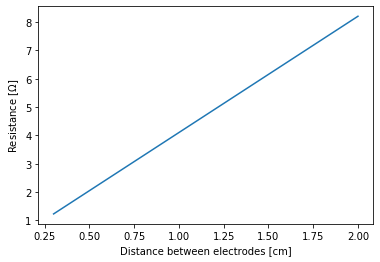

In [18]:
thiccs = np.linspace(.3,2)
As = np.ones_like(thiccs)*100*100
ks = np.ones_like(thiccs)*k
rs = ohmic_resistance(As,thiccs,ks)

plt.plot(thiccs, rs)
plt.xlabel('Distance between electrodes [cm]')
plt.ylabel('Resistance [$\Omega$]')

In [19]:
def P_losses(w,i):
    '''
    takes width between two electrodes in meters
    i in Amps/m^2
    returns power loss in WATTS
    '''
    #pass POWER Active area too ? 
    P_pump_kW = POWER(w) #kW
    P_pump = P_pump_kW*1000 #W
    
    #TRY at different currents 
#     i_mA = 100 #mA/m^2
    A = 1 #m^2
    P_ohmic_losses = (i*A)**2*ohmic_resistance(A,w*cm,k)
#     P_ohmic_losses = 0
    
    return P_pump + P_ohmic_losses

P_losses(.1*cm,1)

0.7453077329379858

Text(0.5, 1.0, 'Power loss based on distance between electrodes')

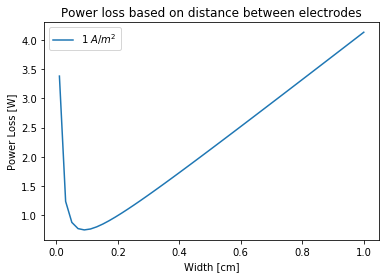

In [20]:
ws = np.linspace(0.01*cm,1*cm)
power_losses_1000=P_losses(ws,np.ones_like(ws)*1000)
power_losses_200=P_losses(ws,np.ones_like(ws)*200)
power_losses_100=P_losses(ws,np.ones_like(ws)*100)
power_losses_50=P_losses(ws,np.ones_like(ws)*50)
power_losses_10=P_losses(ws,np.ones_like(ws)*10)
power_losses_1=P_losses(ws,np.ones_like(ws)*1)
power_losses_p1=P_losses(ws,np.ones_like(ws)*.1)

# plt.plot(ws*100,power_losses_1000,label='1000 $A/m^2$')
# plt.xlim(0,1e-3)
# plt.ylim(0,1e3)
# plt.plot(ws*100,power_losses_200,label='200 $A/m^2$')
# plt.plot(ws*100,power_losses_100,label='100 $A/m^2$')
# plt.plot(ws*100,power_losses_50,label='50 $A/m^2$')
# plt.plot(ws*100,power_losses_10,label='10 $A/m^2$')
plt.plot(ws*100,power_losses_1,label='1 $A/m^2$')
plt.legend()

plt.xlabel('Width [cm]')
plt.ylabel('Power Loss [W]')
plt.title('Power loss based on distance between electrodes')
# plt.savefig('Power_losses.png',dpi=200)
# P_losses(.1*cm,100)/1000

To decide how far apart to position the electrodes, an optimization problem was set up. The closer the electrodes, the lower the ohmic losses, but the more power required to pump the electrolyte. At low current densities, like 1 A/m^2, there exists an optimal width between electrodes to minimize both ohmic losses and losses due to friction. However, at the current densities expected for this design (100-1000 A/m^2), ohmic losses outweigh losses due to friction, and the optimal distance is close to zero. Thus, the electrodes will be  

In [21]:
index_200 = np.argmin(power_losses_200)
index_100 = np.argmin(power_losses_100)
index_10 = np.argmin(power_losses_10)
index_1 = np.argmin(power_losses_1)
index_p1 = np.argmin(power_losses_p1)

ws[index_100]*100 ,ws[index_10]*100, ws[index_1]*100, ws[index_p1]*100

(0.01, 0.01, 0.09081632653061225, 0.8989795918367347)

0.0001 0.01


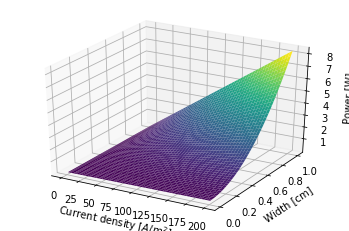

In [22]:
print(ws[0],ws[-1])


current_densities = np.linspace(.1,200,len(ws))
Is,Ws = np.meshgrid(current_densities,ws)
Ps = P_losses(Is,Ws)

ax = plt.axes(projection='3d')
ax.plot_surface(Is, Ws*100, Ps, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
# ax.view_init(15, 200)
ax.set_xlabel('Current density [$A/m^2$]')
ax.set_ylabel('Width [cm]')
ax.set_zlabel('Power [W]');

In [23]:
np.min(Ps)

0.0027980125088659397

In [24]:
Ps[0,0]

0.004045114993929227

In [25]:
#V = ir

In [26]:
def vol_flow(l,w):
    '''
    takes l, w in meters and returns volumetric flow rate in m^3/s
    linear velocity defined above in m/s
    '''
    return linear_velocity*l*w

ls = np.linspace(20*cm,1) #from 20cm to 1m
ws = np.linspace(.3*cm,10*cm,len(ls)) #from .3 to 10cm
Ls,Ws = np.meshgrid(ls,ws)
Qs = vol_flow(Ls,Ws)



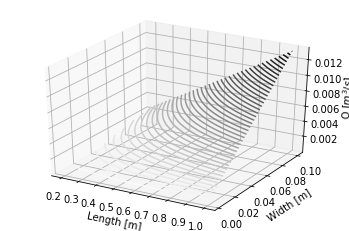

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(Ls, Ws, Qs, 50, cmap='binary')
ax.set_xlabel('Length [m]')
ax.set_ylabel('Width [m]')
ax.set_zlabel('Q [$m^3/s$]');

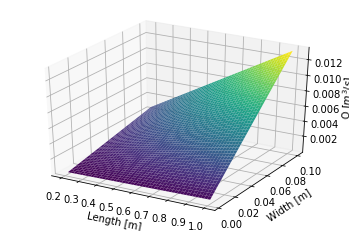

In [28]:
ax = plt.axes(projection='3d')
ax.plot_surface(Ls, Ws, Qs, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
# ax.view_init(0, 90)
ax.set_xlabel('Length [m]')
ax.set_ylabel('Width [m]')
ax.set_zlabel('Q [$m^3/s$]');

In [29]:
def channel_flow(N_G,q_C):
    q_G = q_C/N_G 
    return q_G